(compose_own_plot)=
# Create your own figure with `PlotCollection`

:::{warning} work in progress
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import xarray as xr

plt.rcParams["figure.figsize"] = [8, 5]
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# generate data ------------------------------------------------------------------------
n_groups = 4
group_size = [2, 4, 6, 8]

# Group-specific parameters
slopes = rng.normal(1, 0.2, size=n_groups)
intercepts = rng.normal(0, 1, size=n_groups)

# Generate data
data = []
for i in range(n_groups):
    n = group_size[i]
    x_vals = np.sort(rng.uniform(0, 20, size=n))
    noise = rng.normal(0, 1, size=n)
    y_vals = slopes[i] * x_vals + intercepts[i] + noise
    group_labels = np.full(n, i)
    data.append(pd.DataFrame({"x": x_vals, "y": y_vals, "group": group_labels}))

# Combine all groups into a single DataFrame
df = pd.concat(data, ignore_index=True)
df["group"] = df["group"].astype("category")

# Build a PyMC model -------------------------------------------------------------------
prior_mean = 0
prior_std = 1

x_data = df.x.values
y_data = df.y.values

coords = {"groups": df["group"].cat.categories, "obs_ind": df.index}

with pm.Model(coords=coords) as _m:
    x = pm.Data("x", x_data, dims="obs_ind")
    y = pm.Data("y", y_data, dims="obs_ind")
    group = pm.Data("group", df["group"].cat.codes.values, dims="obs_ind")
    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims=["groups"])
    beta = pm.Normal("beta", mu=prior_mean, sigma=prior_std, dims=["groups"])
    sigma = pm.HalfNormal("sigma", sigma=5)
    # likelihood
    mu = pm.Deterministic("mu", intercept[group] + beta[group] * x, dims="obs_ind")
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y, dims="obs_ind")
    # sample
    idata = pm.sample()

# Generate a grid of points to evaluate on ---------------------------------------------
n_interp_points = 20
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_interp_points)
        for group in df.groupby("group")
    ]
)
g = np.concatenate([[i] * n_interp_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "group": g, "y": np.zeros_like(xi)}

# Posterior prediction on the grid of points -------------------------------------------
coords = {"groups": predict_at["group"], "obs_ind": np.arange(len(xi))}

with _m:
    pm.set_data(predict_at, coords=coords)
    idata.extend(
        pm.sample_posterior_predictive(
            idata,
            var_names=["mu", "y"],
            random_seed=rng,
            progressbar=False,
            predictions=True,
        )
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/tmp/ipykernel_125168/1962420592.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group in df.groupby("group")
Sampling: []


In [2]:
pred_data = idata.predictions_constant_data.set_coords("group")
pred_data

<xarray.Dataset> Size: 2kB
Dimensions:  (obs_ind: 80)
Coordinates:
  * obs_ind  (obs_ind) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_ind) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_ind) float64 640B 2.562 2.902 3.241 3.58 ... 12.26 12.83 13.4
Attributes:
    created_at:                 2025-05-13T12:14:13.847356+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

In [3]:
predictions = idata.predictions.assign_coords(group=pred_data["group"])
predictions

<xarray.Dataset> Size: 5MB
Dimensions:  (chain: 4, draw: 1000, obs_ind: 80)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_ind  (obs_ind) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_ind) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
Data variables:
    mu       (chain, draw, obs_ind) float64 3MB 3.779 3.983 ... 14.32 14.97
    y        (chain, draw, obs_ind) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    created_at:                 2025-05-13T12:14:13.842294+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

In [4]:
data = xr.merge((idata.constant_data, idata.observed_data)).set_coords("group")
data

<xarray.Dataset> Size: 560B
Dimensions:  (obs_ind: 20)
Coordinates:
  * obs_ind  (obs_ind) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    group    (obs_ind) int32 80B 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_ind) float64 160B 2.562 9.008 4.545 8.868 ... 9.391 9.514 13.4
    obs      (obs_ind) float64 160B 1.647 8.383 2.666 ... 11.06 11.86 15.82
Attributes:
    created_at:                 2025-05-13T12:14:13.528044+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

## Option 1: quick exploration

In [5]:
import arviz_stats as azs
import arviz_plots as azp
import arviz_base as azb

In [6]:
def line_ribbon_dots(da, target, x_pred, x, y, **kwargs):
    hdi = da.azstats.hdi()
    target.fill_between(x_pred, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), **kwargs)
    target.plot(x_pred, da.mean(dim=["chain", "draw"]), **kwargs)
    target.scatter(x, y, **kwargs)

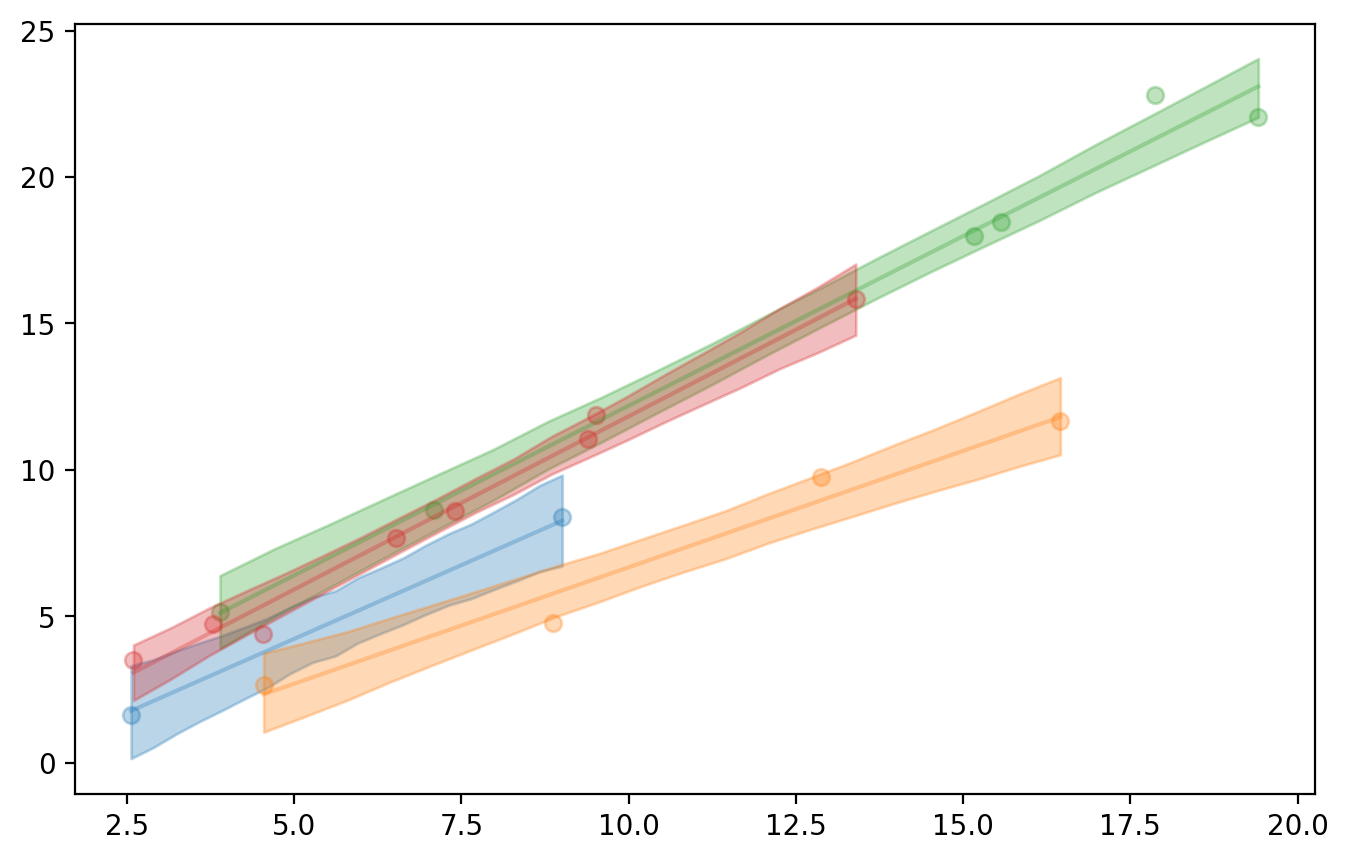

In [7]:
pc = azp.PlotCollection.grid(
    predictions[["mu"]],
    aes={"color": ["group"]},
)
pc.map(line_ribbon_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"], alpha=0.3)

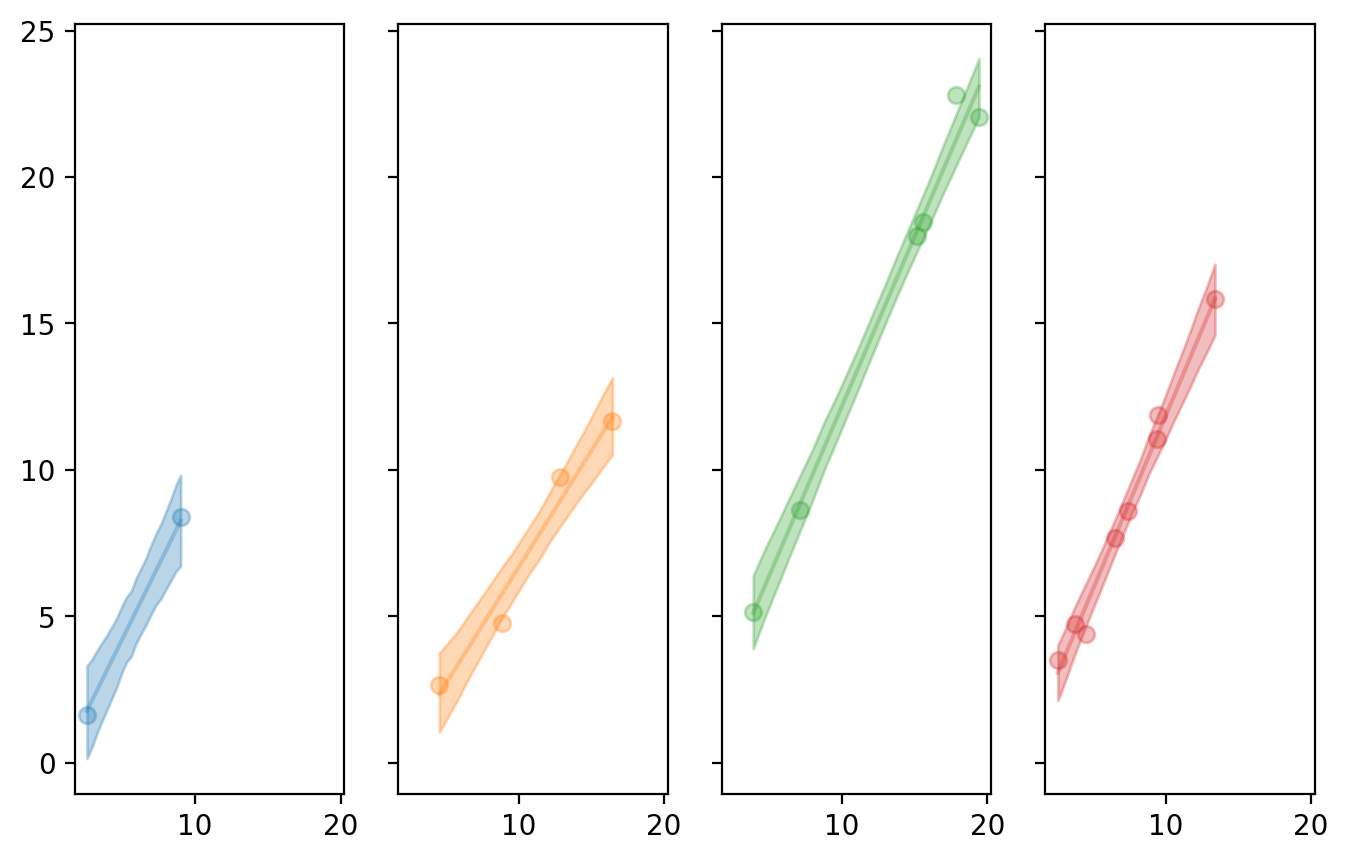

In [8]:
pc = azp.PlotCollection.grid(
    predictions[["mu"]],
    cols=["group"],
    aes={"color": ["group"]},
    figure_kwargs={"sharex": True, "sharey": True}
)
pc.map(line_ribbon_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"], alpha=0.3)

## Option 2: artist specific functions

In [9]:
def hdi_band(da, target, x, **kwargs):
    return target.fill_between(x, da.sel(hdi="lower"), da.sel(hdi="higher"), **kwargs)

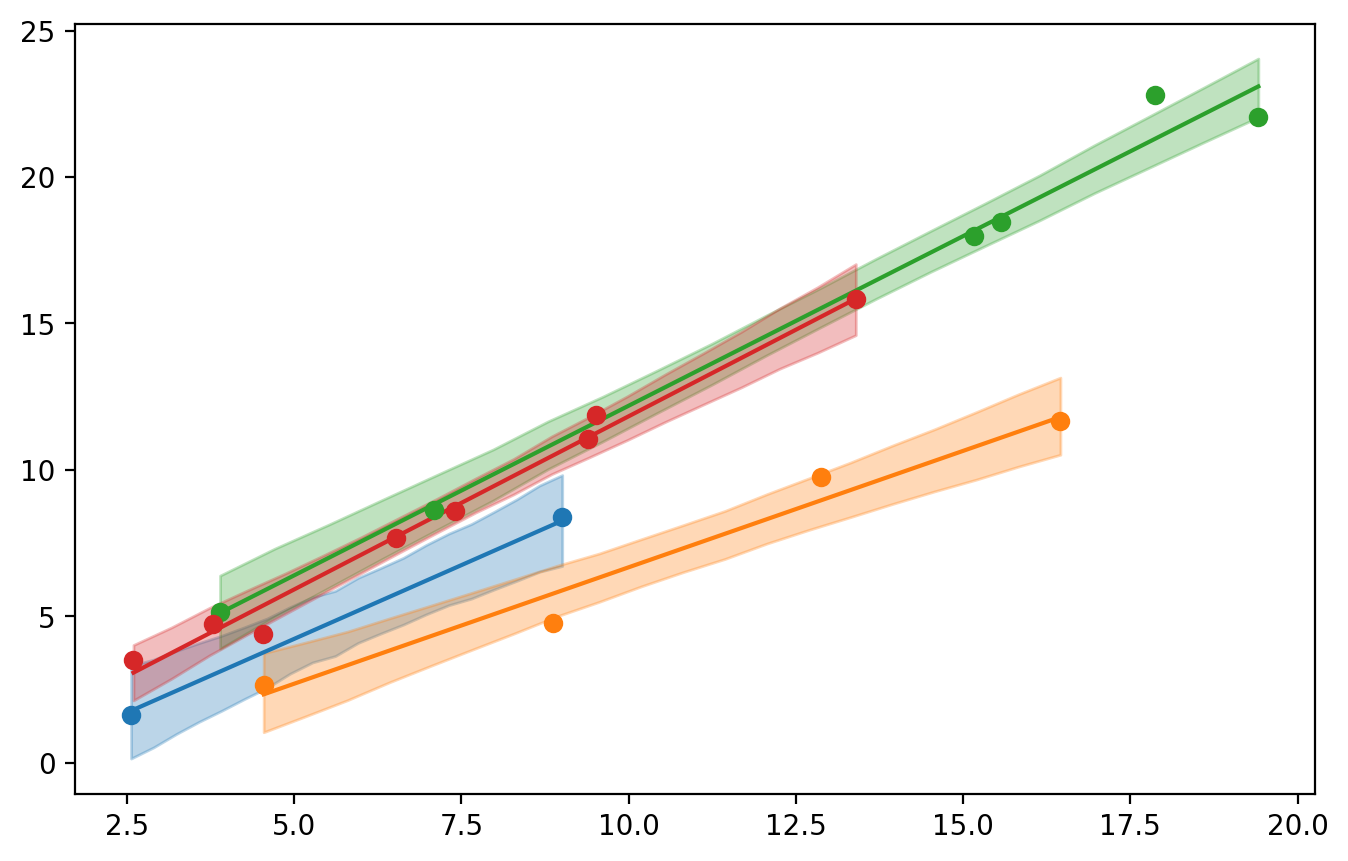

In [10]:
ds = predictions[["mu"]]
pc = azp.PlotCollection.grid(
    ds,
    aes={"color": ["group"]},
)
pc.map(hdi_band, data=ds.azstats.hdi(), x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=ds.mean(["chain", "draw"]), x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, data=data[["obs"]], x=data["x"])

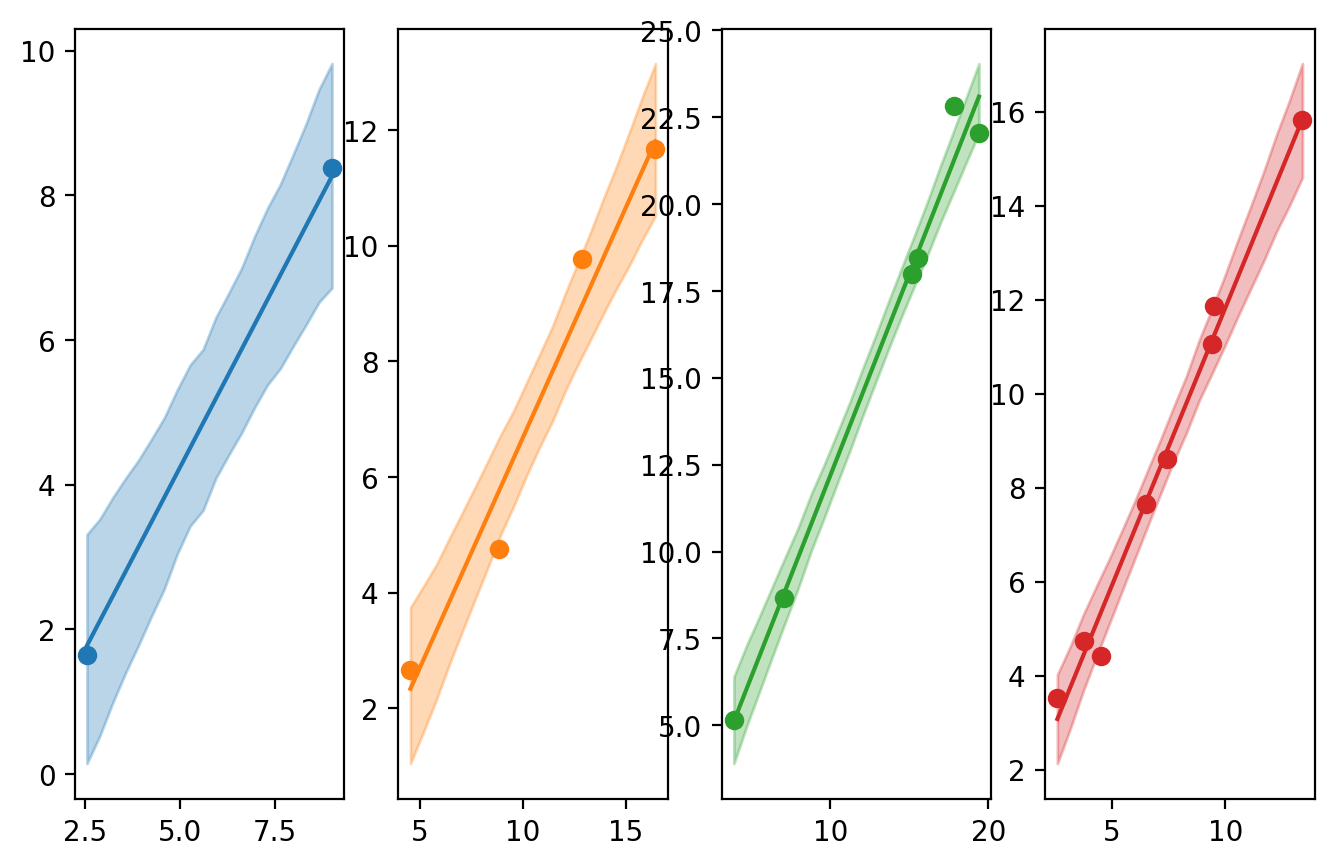

In [11]:
ds = predictions[["mu"]]
pc = azp.PlotCollection.grid(
    ds,
    cols=["group"],
    aes={"color": ["group"]},
)
pc.map(hdi_band, data=ds.azstats.hdi(), x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=ds.mean(["chain", "draw"]), x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, data=data[["obs"]], x=data["x"])

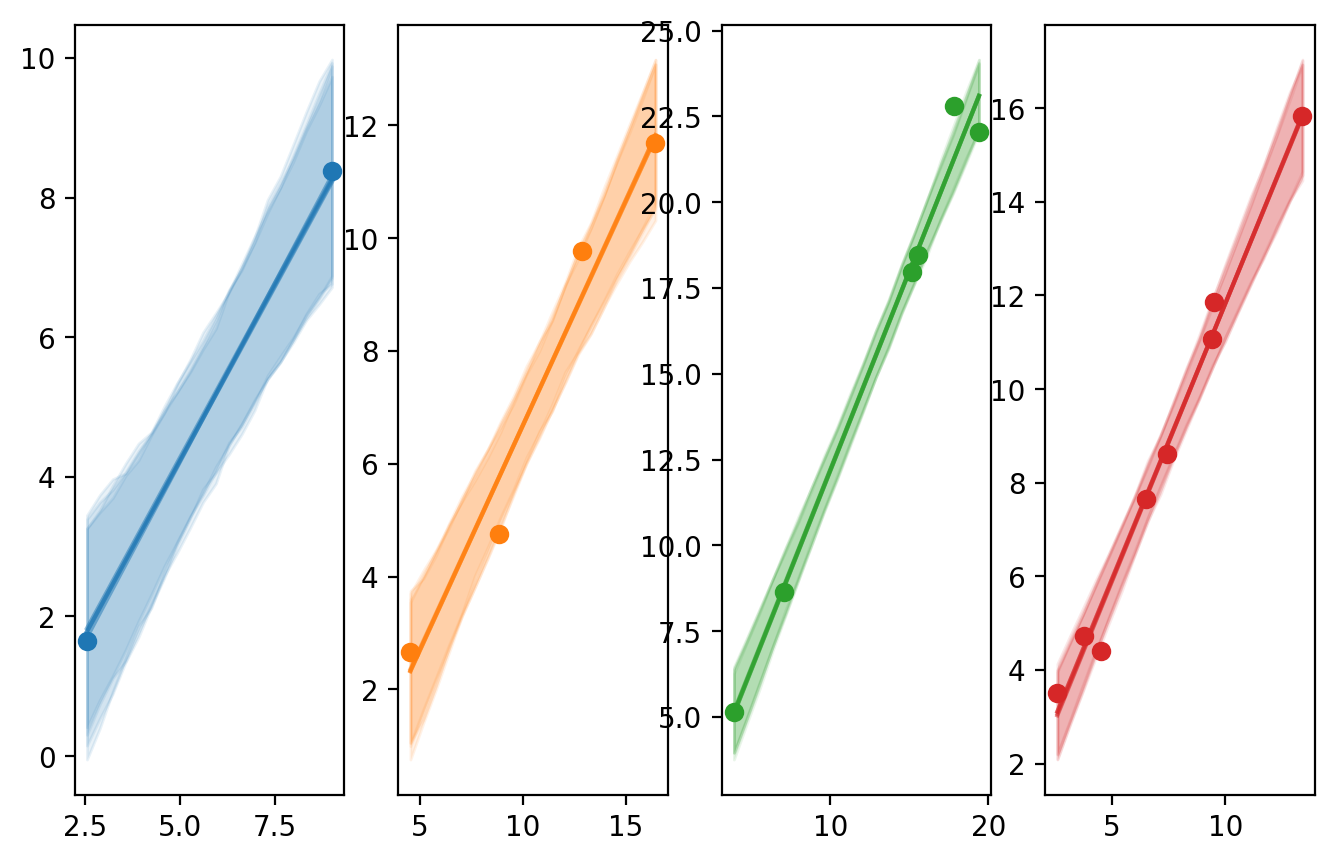

In [12]:
ds = predictions[["mu"]]
pc = azp.PlotCollection.grid(
    ds,
    cols=["group"],
    aes={"color": ["group"], "overlay": ["chain"]},
)
pc.map(hdi_band, data=ds.azstats.hdi(dims=["draw"]), x=pred_data["x"], alpha=0.1)
pc.map(azp.visuals.line_xy, data=ds.mean("draw"), x=pred_data["x"], alpha=0.5)
pc.map(azp.visuals.scatter_xy, data=data["obs"], x=data["x"])